In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
file_names = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        file_names.append(os.path.join(dirname,filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
png_files = []
for i in range(len(file_names)):
    if ".png" in file_names[i]:
        png_files.append(file_names[i])
print(len(file_names))
print(len(png_files))

8002
5334


In [4]:
masks_array =[]
images_array = []
for i in range(len(file_names)):
    if "masks" in file_names[i]:
        masks_array.append(file_names[i])
    if "images" in file_names[i]:
        images_array.append(file_names[i])
print(len(masks_array))
print(len(images_array))
        

2667
2667


[]

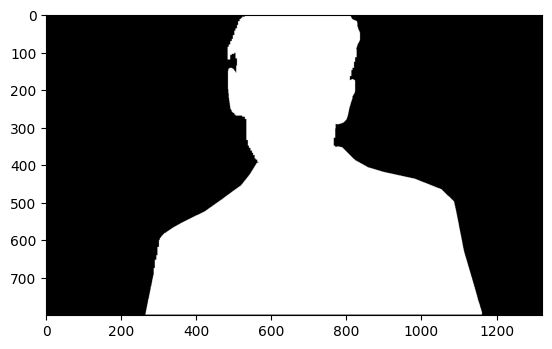

In [5]:
import matplotlib.pyplot as plt 
image = plt.imread("/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks/ds2_portrait-black-and-white-lofty-tone-european-157759.png")
plt.imshow(image)
plt.plot()

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def return_numpy_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB
        image_np = np.array(image)                     # Convert to NumPy
        image_cropped = image_np[:256, :256, :3]       # Now slicing works
        return image_cropped
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

mask_array_numpy = []
image_array_numpy = []
for i in range(len(images_array)):
    returned_array = return_numpy_image(masks_array[i])
    mask_array_numpy.append(returned_array)
    returned_array1 = return_numpy_image(images_array[i])
    image_array_numpy.append(returned_array1)

    
mask_array_numpy = np.asarray(mask_array_numpy)
image_array_numpy = np.asarray(image_array_numpy)
    

(256, 256, 3)
[0 0 0]


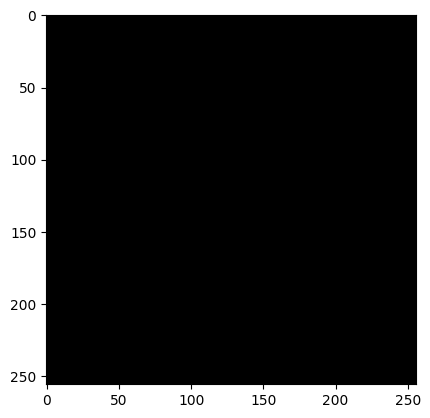

(256, 256, 3)
[255 255 255]


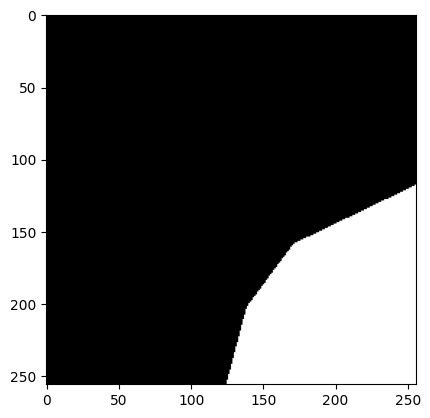

(256, 256, 3)
[0 0 0]


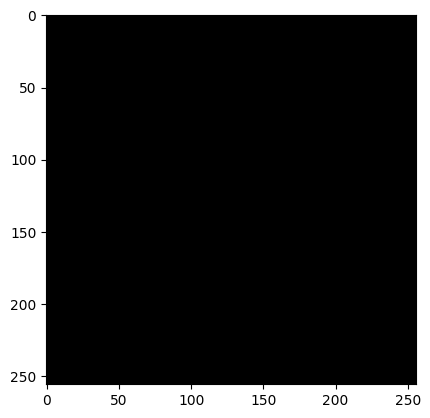

(256, 256, 3)
[255 255 255]


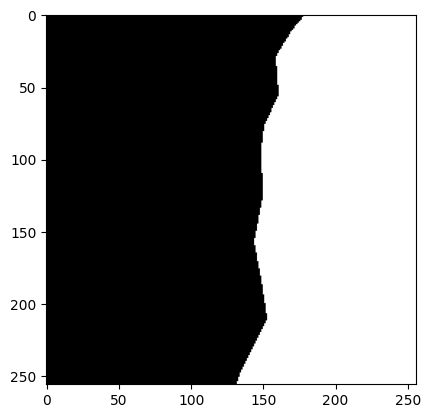

(256, 256, 3)
[0 0 0]


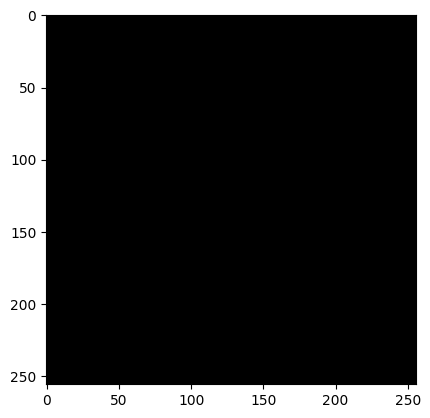

(256, 256, 3)
[0 0 0]


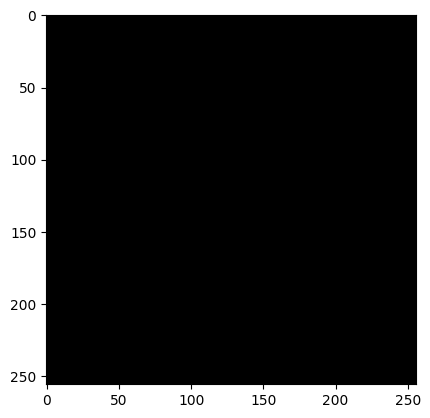

(256, 256, 3)
[0 0 0]


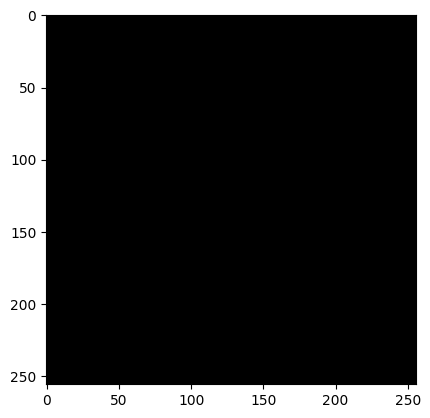

(256, 256, 3)
[0 0 0]


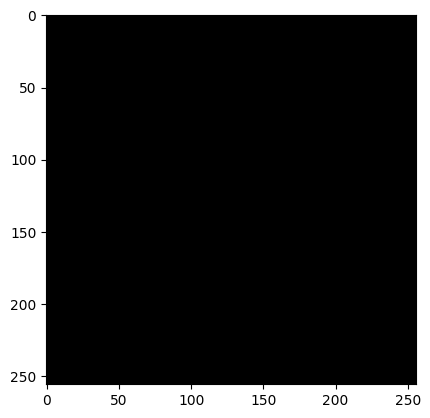

(256, 256, 3)
[0 0 0]


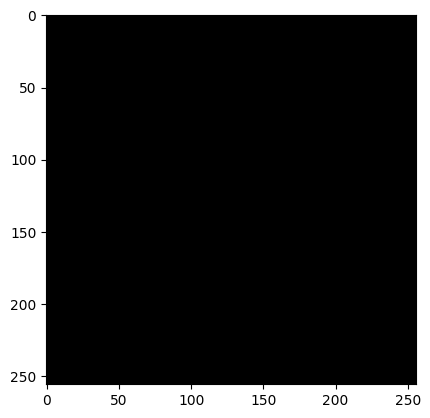

(256, 256, 3)
[0 0 0]


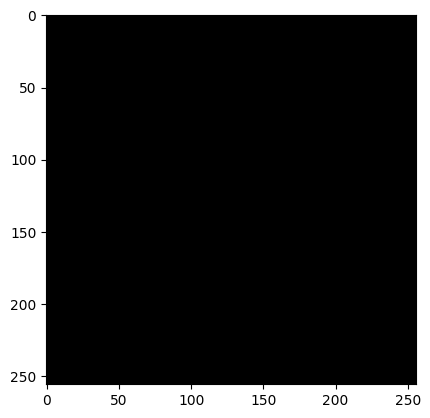

In [7]:
for i in range(10):
    plt.imshow(mask_array_numpy[i][:,:])
    print(mask_array_numpy[i].shape)
    print(mask_array_numpy[i][255,255])
    plt.show()
    

In [8]:
def convert_to_semantic(file):
    numpy_array = np.zeros((256,256,1),dtype = np.uint8)
    for i in range(256):
        for j in range(256):
            l,m,n = file[i,j]
            if [l,m,n] == [255,255,255]:
                numpy_array[i,j]=1
    return numpy_array


masked_numpy_array = []
for i in range(len(mask_array_numpy)):
    image = convert_to_semantic(mask_array_numpy[i])
    masked_numpy_array.append(image)

print(len(masked_numpy_array))
masked_numpy_array = np.asarray(masked_numpy_array)

    
    

2667


In [9]:
train_image = images_array[:1000]
train_image_second = images_array[1000:2000]
valid_image = images_array[2000:2300]
test_image = images_array[2300:]


train_mask = masked_numpy_array[:1000]
train_mask_second = masked_numpy_array[1000:2000]
valid_mask = masked_numpy_array[2000:2300]
test_mask = masked_numpy_array[2300:]


In [10]:
#the data is prepared 
#now having created  the data lets create  the baseline unet model 
#now we have the original image and the corresponding semantic map
#Now lets create the baseline unet model 

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, AveragePooling2D, 
    Dense, Concatenate, Input, Multiply
)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.initializers import HeNormal
from keras.utils import plot_model




2025-05-01 04:21:58.279612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746073318.472701      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746073318.533520      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
#now first lets create the baseline unet model 
def convolution_block(previous_layer, number_of_filters):
    CONV_1 = Conv2D(number_of_filters,padding = "same",activation = "relu", kernel_size = (3,3))(previous_layer)
    CONV_2 = Conv2D(number_of_filters, padding = "same", activation = "relu", kernel_size = (3,3))(CONV_1)
    return CONV_2

input = Input((256,256,3))
#now we pass it through a layer of convolution layers 
input_conv = Conv2D(64,(3,3),activation = 'relu',padding = 'same',kernel_initializer = HeNormal())(input)
k_1 = convolution_block(input_conv,64)
maxpool_layer = MaxPooling2D()(k_1)
k_2 = convolution_block(maxpool_layer,64)
maxpool_layer2 = MaxPooling2D()(k_2)
k_3 = convolution_block(maxpool_layer2,32)
maxpool_layer3 = MaxPooling2D()(k_3)
k_4  = convolution_block(maxpool_layer3, 16)
#now i have coded the  encoder layer of the unet , now lets try to code the decoder layer of the unet mode 
k_5  = convolution_block(k_4,32)
upsample_1 = UpSampling2D((2,2))(k_5)
concatenate = Concatenate()([upsample_1,k_3])
k_6 = convolution_block(concatenate,64)
upsample_2 = UpSampling2D((2,2))(k_6)
convolution = Conv2D(64,(3,3),padding = "same", activation = "relu")(upsample_2)
k_7 = Concatenate()([convolution,k_2])
k_8 = convolution_block(k_7,64)

upsample_2 = UpSampling2D((2,2))(k_8)
k_9 = Conv2D(64,(3,3), padding = "same", activation = "relu")(upsample_2)
k_10 = Concatenate()([k_9,k_1])
k_13 = convolution_block(k_10 ,10)
k_15 = Conv2D(1,(1,1), activation = "sigmoid", padding = "same")(k_13)


#now lets wrap the model 
baseline_unet_model = Model(inputs = input, outputs = k_15)
baseline_unet_model.summary()






I0000 00:00:1746073339.965642      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 32)     │         18,464 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 32)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 16)     │          4,624 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 16)     │          2,320 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 32)     │              0 │ conv2d_10[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 64)     │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 468,931 (1.79 MB)

 Trainable params: 468,931 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#now we have denormalized the image . 
#next we now try to build the unet model , infused with attention 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input

from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, AveragePooling2D, 
    Dense, Concatenate, Input, Multiply
)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model

class TeacherNetwork:
    def __init__(self, weight, reduction_amount):
        self.activation = "relu"
        self.padding = "same"
        self.kernel_size = (3, 3)
        self.weight = weight  # Importance given to avg pooling
        self.reduction_amount = reduction_amount

    def encoder_layer(self, filters, last_layer):
        output1 = Conv2D(filters, self.kernel_size, activation=self.activation, padding=self.padding)(last_layer)
        output2 = Conv2D(filters, self.kernel_size, activation=self.activation, padding=self.padding)(output1)
        batchnorm4 = BatchNormalization()(output2)
        maxpool_layer = MaxPooling2D()(batchnorm4)
        return output2, maxpool_layer

    def decoder_layer(self, filters, last_layer):
        output1 = Conv2D(filters, self.kernel_size, activation=self.activation, padding=self.padding)(last_layer)
        batchnorm3= BatchNormalization()(output1)
        output2 = Conv2D(filters, self.kernel_size, activation=self.activation, padding=self.padding)(batchnorm3)
        upsample_layer = UpSampling2D(size=(2,2), interpolation="nearest")(output2)
        return upsample_layer
    def channel_attention_layer(self, input_tensor, filters):
        pooled_tensor = MaxPooling2D()(input_tensor)
        avg_pool = GlobalAveragePooling2D()(pooled_tensor)

        avg_pool1 = AveragePooling2D((2, 2))(input_tensor)
        avg_pool2 = GlobalAveragePooling2D()(avg_pool1)

    # First branch
        dense_layer = Dense(filters, activation="relu")(avg_pool)
        dense_layer1 = Dense(filters // 2, activation="relu")(dense_layer)
        dense_layer2 = Dense(filters, activation="relu")(dense_layer1)

    # Second branch
        dense_layer3 = Dense(filters, activation="relu")(avg_pool2)
        dense_layer4 = Dense(filters // 2, activation="relu")(dense_layer3)
        dense_layer5 = Dense(filters, activation="relu")(dense_layer4)

    # Concatenate and final squeeze
        concatenate_layer = Concatenate(axis=-1)([dense_layer2, dense_layer5])
        dense_layer6 = Dense(filters, activation="sigmoid")(concatenate_layer)

    # ✅ Corrected reshape
        attention = tf.keras.layers.Reshape((1, 1, filters))(dense_layer6)
        output_filters = input_tensor * attention
        return output_filters


    def spatial_attention_layer(self, input_tensor, filters):
        input_tensor1 = self.channel_attention_layer(input_tensor, filters)

        maxpool_tensor = MaxPooling2D((2, 2))(input_tensor1)
        average_tensor = AveragePooling2D((2, 2))(input_tensor1)

        # Adjust importance
        average_tensor = self.weight * average_tensor
        maxpool_tensor = (1 - self.weight) * maxpool_tensor

        concatenated_filters = Concatenate(axis=-1)([average_tensor, maxpool_tensor])
        convolution_filter = Conv2D(filters, (3,3), padding="same", activation="relu",kernel_initializer =  HeNormal())(concatenated_filters)
        batchnorm5 = BatchNormalization()(convolution_filter)
        convolution_filter2 = Conv2D(1, (3,3), padding="same", activation="sigmoid")(batchnorm5)
        batchnorm6 = BatchNormalization()(convolution_filter2)

        upsampled_filter = UpSampling2D((2,2))(batchnorm6)
        spatial_filter= input_tensor1*upsampled_filter
        return spatial_filter

    def attention_block(self, input_tensor, filters):
        return self.spatial_attention_layer(input_tensor, filters)

    def build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        input_conv = Conv2D(16,(3,3),padding = "same",activation ="relu" , kernel_initializer = HeNormal())(inputs)
        
        enc1, pool1 = self.encoder_layer(16, input_conv)
        enc2, pool2 = self.encoder_layer(32, pool1)
        enc3, pool3 = self.encoder_layer(32, pool2)
        enc4, _ = self.encoder_layer(64, pool3)

        att1 = self.attention_block(enc1, 16)
        att2 = self.attention_block(enc2, 32)
        att3 = self.attention_block(enc3, 32)


        
        dec6 = self.decoder_layer(64, enc4)
        concat5 = Concatenate(axis=-1)([att3, dec6])
        dec5 = self.decoder_layer(32, concat5)

        concat4 = Concatenate(axis=-1)([att2, dec5])
        dec4 = self.decoder_layer(32, concat4)

        concat3 = Concatenate(axis=-1)([att1, dec4])
        dec3 = self.decoder_layer(16, concat3)

        maxpool_layer = MaxPooling2D()(dec3)

        concat1 = Concatenate(axis=-1)([att1, maxpool_layer])
        batchnorm11 = BatchNormalization()(concat1)
        output_tensor1 = Conv2D(20, (3, 3), activation=self.activation, padding=self.padding)(batchnorm11)
        output_tensor1 = Conv2D(20, (3, 3), activation=self.activation, padding=self.padding)(batchnorm11)

        output_tensor1 = Conv2D(15, (3, 3), activation=self.activation, padding=self.padding)(batchnorm11)
        output_tensor1 = Conv2D(15, (3, 3), activation=self.activation, padding=self.padding)(batchnorm11)
        
        batchnorm12 = BatchNormalization()(output_tensor1)
        output_tensor3 = Conv2D(10,(3,3),activation = self.activation,padding = self.padding)(batchnorm12)
        
        output_tensor4 = Conv2D(5,(3,3),activation = "relu",padding = "same")(output_tensor3)
        output_tensor2 = Conv2D(1, (1, 1), activation="sigmoid", padding=self.padding)(output_tensor3)
        

        #output_tensor3 = Lambda(lambda x: tf.squeeze(x, axis=-1))(output_tensor2)


        return Model(inputs, output_tensor2)

In [34]:
#after creating the class , lets now create an object 

teacher_unet = TeacherNetwork(0.5,2)
teacher_model = teacher_unet.build_model((256,256,3))
teacher_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_144 (Conv2D)       │ (None, 256, 256, 16)   │            448 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_145 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ conv2d_144[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_146 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ conv2d_145[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 256, 256, 16)   │             64 │ conv2d_146[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_47          │ (None, 128, 128, 16)   │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_147 (Conv2D)       │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_47[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_148 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_147[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 128, 128, 32)   │            128 │ conv2d_148[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_48          │ (None, 64, 64, 32)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_149 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ max_pooling2d_48[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_150 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ conv2d_149[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_55          │ (None, 32, 32, 32)     │              0 │ conv2d_150[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_32      │ (None, 32, 32, 32)     │              0 │ conv2d_150[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_55[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 304,341 (1.16 MB)

 Trainable params: 303,633 (1.16 MB)

 Non-trainable params: 708 (2.77 KB)

In [35]:
plot_model(teacher_model,show_layer_names =True)

In [36]:
#here we design the heirarchical attention 
def conv_block(input_layer,number_of_filters):
    conv_1 = Conv2D(number_of_filters,(3,3),padding= "same",activation = "relu")(input_layer)
    conv_2 = Conv2D(number_of_filters, (3,3), padding = "same", activation = "relu")(conv_1)
    return conv_2


def spatial_attention_layer(input_tensor, filters):
    pooled_tensor = MaxPooling2D()(input_tensor)
    avg_pool = GlobalAveragePooling2D()(pooled_tensor)

    avg_pool1 = AveragePooling2D((2, 2))(input_tensor)
    avg_pool2 = GlobalAveragePooling2D()(avg_pool1)

    # First branch
    dense_layer = Dense(filters, activation="relu")(avg_pool)
    dense_layer1 = Dense(filters // 2, activation="relu")(dense_layer)
    dense_layer2 = Dense(filters, activation="relu")(dense_layer1)

    # Second branch
    dense_layer3 = Dense(filters, activation="relu")(avg_pool2)
    dense_layer4 = Dense(filters // 2, activation="relu")(dense_layer3)
    dense_layer5 = Dense(filters, activation="relu")(dense_layer4)
    # Concatenate and final squeeze
    concatenate_layer = Concatenate(axis=-1)([dense_layer2, dense_layer5])
    dense_layer6 = Dense(filters, activation="sigmoid")(concatenate_layer)

    # ✅ Corrected reshape
    attention = tf.keras.layers.Reshape((1, 1, filters))(dense_layer6)
    output_filters = input_tensor * attention

    maxpool_tensor = MaxPooling2D((2, 2))(output_filters)
    average_tensor = AveragePooling2D((2, 2))(output_filters)

    concatenated_filters = Concatenate(axis=-1)([average_tensor, maxpool_tensor])
    convolution_filter = Conv2D(filters, (3,3), padding="same", activation="relu",kernel_initializer =  HeNormal())(concatenated_filters)
    batchnorm5 = BatchNormalization()(convolution_filter)
    convolution_filter2 = Conv2D(1, (3,3), padding="same", activation="sigmoid")(batchnorm5)
    batchnorm6 = BatchNormalization()(convolution_filter2)

    upsampled_filter = UpSampling2D((2,2))(batchnorm6)
    spatial_filter= output_filters*upsampled_filter
    return spatial_filter

def hierarchical_attention_block(attention_tensor1,attention_tensor2,number_of_filters):
    upsampled_feature = UpSampling2D()(attention_tensor2)
    feature_2 = Conv2D(number_of_filters,(3,3),padding= "same",activation = "relu")(upsampled_feature)
    #lets concatenate the features of the attention tensor 1 and the attention tensior 2 
    concatenate = Concatenate()([attention_tensor1,feature_2])
    #now lets pass this concatenated feature for further  feature extraction 
    feature_3 = Conv2D(number_of_filters, (3,3),activation = "relu", padding = "same")(concatenate)
    
    return feature_3
    
    
input_1 = Input((256,256,3))
layer_1_encoder = conv_block(input_1,16) #concatenate +maxpool layer 

#here we add the spatial attention block 
spatial_attention_layer1 = spatial_attention_layer(layer_1_encoder,16) #first attention layer

maxpool_layer = MaxPooling2D()(layer_1_encoder)
layer_2_encoder = conv_block(maxpool_layer,32) #concatenate +maxpool layer 
spatial_attention_layer2 = spatial_attention_layer(layer_2_encoder,32)  #second attention layer


maxpool_layer1 = MaxPooling2D()(layer_2_encoder)
layer_3_encoder = conv_block(maxpool_layer1,64) #concatenate + maxpool_layer
spatial_attention_layer3 = spatial_attention_layer(layer_3_encoder,64) #third attention layer


#now we add the hierarchical attention for the above 3 layers 
hierarchical_attention_layer2_3 = hierarchical_attention_block(spatial_attention_layer2,spatial_attention_layer3,32)

hierarchical_attention_layer1_2 = hierarchical_attention_block(spatial_attention_layer1,spatial_attention_layer2,16)
#now we code the decoder block , with the output from the hierarchical attention 


maxpool_layer2 = MaxPooling2D()(layer_3_encoder)
layer_4_encoder = conv_block(maxpool_layer2,128) #encoder block end
layer_4_decoder = conv_block(layer_4_encoder,64)
upsampled = UpSampling2D()(layer_4_decoder)
#we now concatenate the upsamples layer and the hierarchcial attention 
hierarchical_upsampled_layer2 = Concatenate()([upsampled,spatial_attention_layer3])

conv_layer_2 = Conv2D(64,(3,3),activation = "relu",padding = "same")(hierarchical_upsampled_layer2)
conv_layer_2_2 = Conv2D(32,(3,3),activation = "relu",padding = "same")(conv_layer_2)

upsampled_2 = UpSampling2D()(conv_layer_2_2)

#now combine with the hierarchical attention of the layer_1 
hierarchical_attention_upsampled_3_2 = Concatenate()([hierarchical_attention_layer2_3,upsampled_2])

conv_block_3_1 = Conv2D(32,(3,3),activation = "relu",padding= "same")(hierarchical_attention_upsampled_3_2)
conv_block_3_2 = Conv2D(16,(3,3),activation = "relu",padding= "same")(conv_block_3_1)

upsampled_4 = UpSampling2D()(conv_block_3_2)

hierarchical_attention_upsampled_2_1 = Concatenate()([hierarchical_attention_layer1_2,upsampled_4])


#after concatenating lets pass it with a serires of convolution blocks 

Conv_layer_1_decoder = Conv2D(16,(3,3),activation = "relu",padding= "same")(hierarchical_attention_upsampled_2_1)
conv_layer_1_decoder_1 = Conv2D(16,(3,3),activation = "relu",padding= "same")(Conv_layer_1_decoder)
Conv_layer_1_decoder_2 = Conv2D(8,(3,3),activation = "relu",padding = "same")(conv_layer_1_decoder_1)
Conv_layer_1_decoder_3 = Conv2D(1,(3,3),activation = "sigmoid", padding = "same")(Conv_layer_1_decoder_2)

hierarchical_teacher_model = Model(inputs = input_1,outputs = Conv_layer_1_decoder_3)

hierarchical_teacher_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_174 (Conv2D)       │ (None, 256, 256, 16)   │            448 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_175 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ conv2d_174[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 128, 128, 16)   │              0 │ conv2d_175[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_178 (Conv2D)       │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_179 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_178[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_63          │ (None, 64, 64, 32)     │              0 │ conv2d_179[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_182 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_63[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_183 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_182[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_64          │ (None, 32, 32, 64)     │              0 │ conv2d_183[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_38      │ (None, 32, 32, 64)     │              0 │ conv2d_183[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ max_pooling2d_64[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ average_pooling2d_38[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 64, 64, 32)     │              0 │ conv2d_179[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_36      │ (None, 64, 64, 32)     │              0 │ conv2d_179[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├──────────────────────

 Total params: 705,216 (2.69 MB)

 Trainable params: 704,986 (2.69 MB)

 Non-trainable params: 230 (920.00 B)

In [49]:
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def convolution_block(number_of_filters,previous_layer):
    conv_1= Conv2D(number_of_filters,(3,3),padding = "same", activation = "relu")(previous_layer)
    conv_2 = Conv2D(number_of_filters,(3,3),padding = "same",activation = "relu")(conv_1)
    return conv_2

def channel_attention_mechanism(starting_layer,filters):
    pooled_tensor = MaxPooling2D()(starting_layer)
    avg_pool = GlobalAveragePooling2D()(pooled_tensor)

        
    avg_pool1= AveragePooling2D((2,2))(starting_layer)

    avg_pool2 = GlobalAveragePooling2D()(avg_pool1)


    dense_layer = Dense(filters, activation="relu")(avg_pool)
    dense_layer1 = Dense(filters // 2, activation="relu")(dense_layer)
    dense_layer2 = Dense(filters, activation="relu")(dense_layer1)


    dense_layer3 = Dense(filters, activation="relu")(avg_pool2)
    dense_layer4 = Dense(filters // 2, activation="relu")(dense_layer3)
    dense_layer5 = Dense(filters, activation="relu")(dense_layer4)

        #now i concatenate the output of the two 
    concatenate_layer = Concatenate(axis = -1)([dense_layer2,dense_layer5])

    dense_layer6 = Dense(filters, activation = "sigmoid")(concatenate_layer)

    dense_layer7 = tf.keras.layers.Reshape((1, 1, filters))(dense_layer6)
        
    output_filters = Multiply()([starting_layer, dense_layer7])
    return output_filters

def spatial_attention_mechanism(starting_layers,filters):
    input_tensor1 = channel_attention_mechanism(starting_layers,filters)

    maxpool_tensor = MaxPooling2D((2, 2))(input_tensor1)
    average_tensor = AveragePooling2D((2, 2))(input_tensor1)


    concatenated_filters = Concatenate(axis=-1)([average_tensor, maxpool_tensor])
    convolution_filter = Conv2D(filters, (3,3), padding="same", activation="relu")(concatenated_filters)
    batchnorm5 = BatchNormalization()(convolution_filter)
    convolution_filter2 = Conv2D(1, (3,3), padding="same", activation="sigmoid")(batchnorm5)
    batchnorm6 = BatchNormalization()(convolution_filter2)

    upsampled_filter = UpSampling2D((2,2))(batchnorm6)
        
    spatial_filter = Multiply()([input_tensor1, upsampled_filter])
    return spatial_filter

intermediate_teacher_model = Model(
    inputs=teacher_model.input,
    outputs=teacher_model.get_layer('concatenate_57').output
)

intermediate_teacher_model1 = Model(
    inputs = teacher_model.input,
    outputs= teacher_model.get_layer('concatenate_56').output
)
    
 
# Now we have created the Teacher UNet model; next, we will create the Student model
#lets create the student model 
input = Input((256,256,3))
conv_1 = convolution_block(16,input)  #concatenate here 
spatial_attention_mechanism_student = spatial_attention_mechanism(conv_1,16)
added_attention_mechanism1 = intermediate_teacher_model(input)
concatenated_layer = Concatenate()([spatial_attention_mechanism_student, added_attention_mechanism1])
added_knowledge1 = Conv2D(16,(3,3),padding = "same", activation = "relu")(concatenated_layer)


maxpool = MaxPooling2D()(conv_1)
conv_2 = convolution_block(32,maxpool) #concatenate here 
spatial_attention_mechanism_student2 = spatial_attention_mechanism(conv_2,32)
added_attention_mechanism2 =intermediate_teacher_model1(input)
concatenated_layer3  = Concatenate()([added_attention_mechanism2,spatial_attention_mechanism_student2])
added_knowledge3 = Conv2D(16,(3,3),padding = "same", activation = "relu")(concatenated_layer3)

maxpool2 = MaxPooling2D()(conv_2)
conv_4 = convolution_block(32,maxpool2)
upsample_layer = UpSampling2D((2,2))(conv_4)
concatenate_layer  = Concatenate()([upsample_layer,added_knowledge3])
conv_5 = convolution_block(16,concatenate_layer)
upsample_layer2 = UpSampling2D((2,2),name = "up_sampling2d_8")(conv_5)
concatenate_layer2= Concatenate()([upsample_layer2,added_knowledge1])
conv_6 = convolution_block(5,concatenate_layer2)
conv_8 = Conv2D(1,(1,1),padding= "same",activation = "sigmoid")(conv_6)

student_model = Model(inputs = input, outputs = conv_8)

student_model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_221 (Conv2D)       │ (None, 256, 256, 16)   │            448 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_222 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ conv2d_221[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_76          │ (None, 128, 128, 16)   │              0 │ conv2d_222[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_226 (Conv2D)       │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_76[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_227 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_226[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_77          │ (None, 64, 64, 32)     │              0 │ conv2d_227[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_47      │ (None, 64, 64, 32)     │              0 │ conv2d_227[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_77[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ average_pooling2d_47[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_168 (Dense)         │ (None, 32)             │          1,056 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_171 (Dense)         │ (None, 32)             │          1,056 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_169 (Dense)         │ (None, 16)             │            528 │ dense_168[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_172 (Dense)         │ (None, 16)             │            528 │ dense_171[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_170 (Dense)         │ (None, 32)             │            544 │ dense_169[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_173 (Dense)         │ (None, 32)             │            544 │ dense_172[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_74     

 Total params: 389,978 (1.49 MB)

 Trainable params: 389,296 (1.49 MB)

 Non-trainable params: 682 (2.66 KB)

In [38]:

import tensorflow as tf
from tensorflow.keras import backend as K


def  iou_score(y_true,y_pred):
    y_true = tf.cast(y_true,dtype = tf.float32)
    y_pred = tf.cast(y_pred,dtype = tf.float32)
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])

    union = tf.reduce_sum(y_true_flatten)+tf.reduce_sum(y_pred_flatten)
    intersection = tf.reduce_sum(y_true_flatten*y_pred_flatten)

    return intersection/union
    


In [51]:
from keras.optimizers import Adam
teacher_model.compile(metrics = [iou_score],optimizer = Adam(learning_rate = 0.0001),loss = "binary_crossentropy")
hierarchical_teacher_model.compile(metrics = [iou_score],optimizer = Adam(learning_rate = 0.0001),loss = "binary_crossentropy")
baseline_unet_model.compile(metrics = [iou_score],optimizer = Adam(learning_rate = 0.0001),loss = "binary_crossentropy")
student_model.compile(metrics = [iou_score],optimizer = Adam(learning_rate = 0.0001),loss = "binary_crossentropy")

In [31]:
train_image = image_array_numpy[:1000]
train_image_second = image_array_numpy[1000:2000]
valid_image = image_array_numpy[2000:2300]
test_image = image_array_numpy[2300:]


train_mask = masked_numpy_array[:1000]
train_mask_second = masked_numpy_array[1000:2000]
valid_mask = masked_numpy_array[2000:2300]
test_mask = masked_numpy_array[2300:]


In [33]:
history = baseline_unet_model.fit(train_image,train_mask,validation_data = (valid_image,valid_mask),epochs =50, batch_size = 32,verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - iou_score: 0.1663 - loss: 0.1485 - val_iou_score: 0.1595 - val_loss: 0.2006
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1811 - loss: 0.1595 - val_iou_score: 0.1547 - val_loss: 0.2053
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1761 - loss: 0.1644 - val_iou_score: 0.1534 - val_loss: 0.1917
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1635 - loss: 0.1620 - val_iou_score: 0.1711 - val_loss: 0.1969
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1812 - loss: 0.1567 - val_iou_score: 0.1703 - val_loss: 0.1831
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1808 - loss: 0.1424 - val_iou_score: 0.1646 - val_loss: 0.1807
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1765 - loss: 0.1321 - val_iou_score: 0.1602 - val_loss: 0.1882
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - iou_score: 0.1793 - loss: 0.

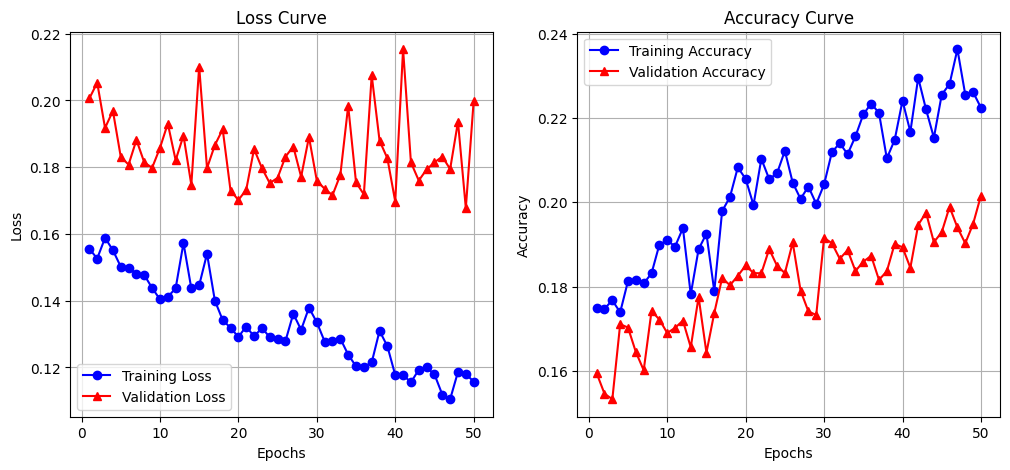

In [40]:
import matplotlib.pyplot as plt

# Extract loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('iou_score', history.history.get('acc'))  # Handle different Keras versions
val_acc = history.history.get('val_iou_score', history.history.get('val_acc'))

epochs = range(1, len(train_loss) + 1)

# 📌 Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' = blue circle markers with line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' = red triangle markers with line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# 📌 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


In [41]:
history = teacher_model.fit(train_image,train_mask,validation_data = (valid_image,valid_mask),epochs =50, batch_size = 32,verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - iou_score: 0.0609 - loss: 0.6117 - val_iou_score: 0.0665 - val_loss: 0.5298
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.0670 - loss: 0.4962 - val_iou_score: 0.0662 - val_loss: 0.5024
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.0763 - loss: 0.4168 - val_iou_score: 0.0644 - val_loss: 0.4617
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.0841 - loss: 0.3461 - val_iou_score: 0.0633 - val_loss: 0.4164
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.0928 - loss: 0.2933 - val_iou_score: 0.0660 - val_loss: 0.3834
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.1063 - loss: 0.2509 - val_iou_score: 0.0701 - val_loss: 0.3325
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.1212 - loss: 0.2217 - val_iou_score: 0.0682 - val_loss: 0.2989
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - iou_score: 0.1370 - loss: 0.2159 - val

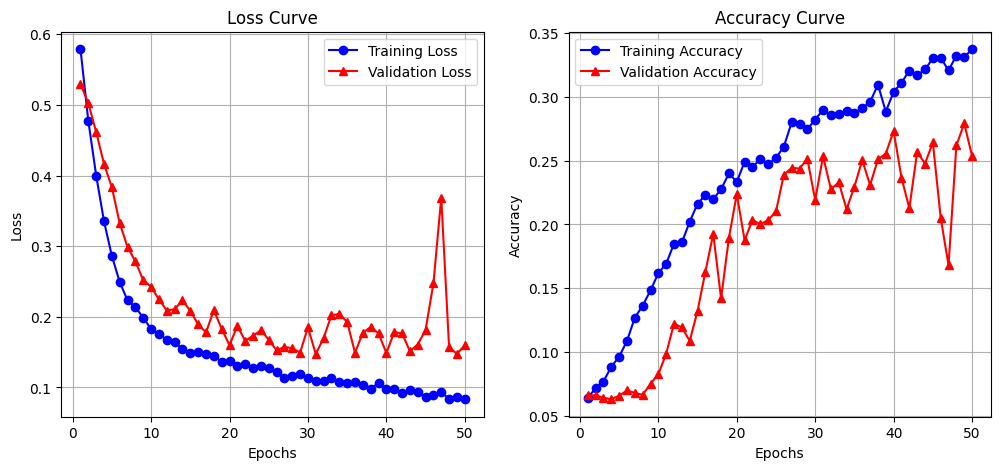

In [42]:
import matplotlib.pyplot as plt

# Extract loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('iou_score', history.history.get('acc'))  # Handle different Keras versions
val_acc = history.history.get('val_iou_score', history.history.get('val_acc'))

epochs = range(1, len(train_loss) + 1)

# 📌 Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' = blue circle markers with line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' = red triangle markers with line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# 📌 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


In [43]:
history = hierarchical_teacher_model.fit(train_image,train_mask,validation_data = (valid_image,valid_mask),epochs =50, batch_size = 32,verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 784ms/step - iou_score: 0.0754 - loss: 0.5369 - val_iou_score: 0.0542 - val_loss: 0.3345
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - iou_score: 0.0699 - loss: 0.2705 - val_iou_score: 0.0661 - val_loss: 0.2819
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - iou_score: 0.1049 - loss: 0.2370 - val_iou_score: 0.0766 - val_loss: 0.2523
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - iou_score: 0.1252 - loss: 0.2112 - val_iou_score: 0.0850 - val_loss: 0.2539
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - iou_score: 0.1412 - loss: 0.1953 - val_iou_score: 0.1057 - val_loss: 0.2360
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - iou_score: 0.1182 - loss: 0.2184 - val_iou_score: 0.0927 - val_loss: 0.2318
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - iou_score: 0.1321 - loss: 0.1923 - val_iou_score: 0.1017 - val_loss: 0.2415
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - iou_score: 0.1484 - loss: 0.1887 - 

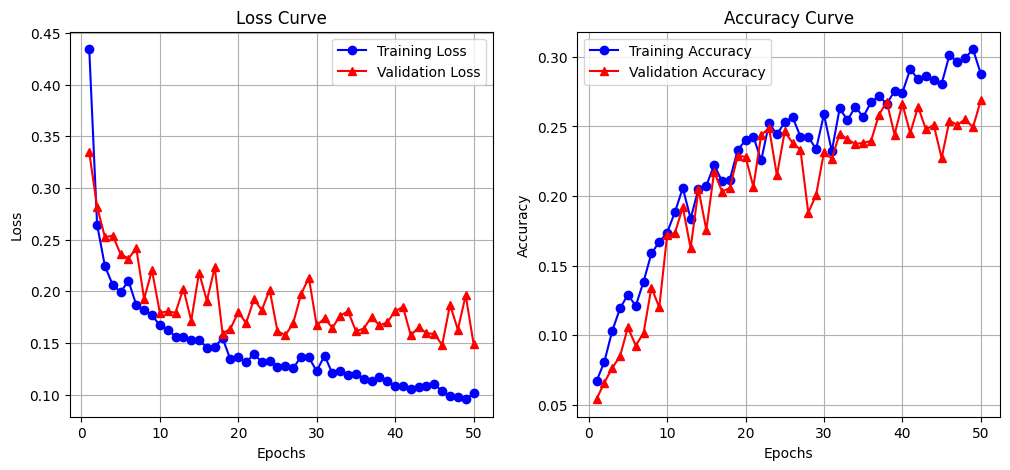

In [44]:
import matplotlib.pyplot as plt

# Extract loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('iou_score', history.history.get('acc'))  # Handle different Keras versions
val_acc = history.history.get('val_iou_score', history.history.get('val_acc'))

epochs = range(1, len(train_loss) + 1)

# 📌 Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' = blue circle markers with line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' = red triangle markers with line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# 📌 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


In [52]:
history = student_model.fit(train_image,train_mask,validation_data = (valid_image,valid_mask),epochs =50, batch_size = 32,verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - iou_score: 0.0636 - loss: 1.0389 - val_iou_score: 0.0673 - val_loss: 0.6989
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.0669 - loss: 0.6939 - val_iou_score: 0.0671 - val_loss: 0.6216
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.0644 - loss: 0.5158 - val_iou_score: 0.0581 - val_loss: 0.3496
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.0587 - loss: 0.3213 - val_iou_score: 0.0765 - val_loss: 0.2862
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.0786 - loss: 0.2576 - val_iou_score: 0.1381 - val_loss: 0.2337
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.1447 - loss: 0.2004 - val_iou_score: 0.1617 - val_loss: 0.2191
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.1834 - loss: 0.1735 - val_iou_score: 0.2024 - val_loss: 0.1915
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - iou_score: 0.2252 - loss: 0.1445 - val

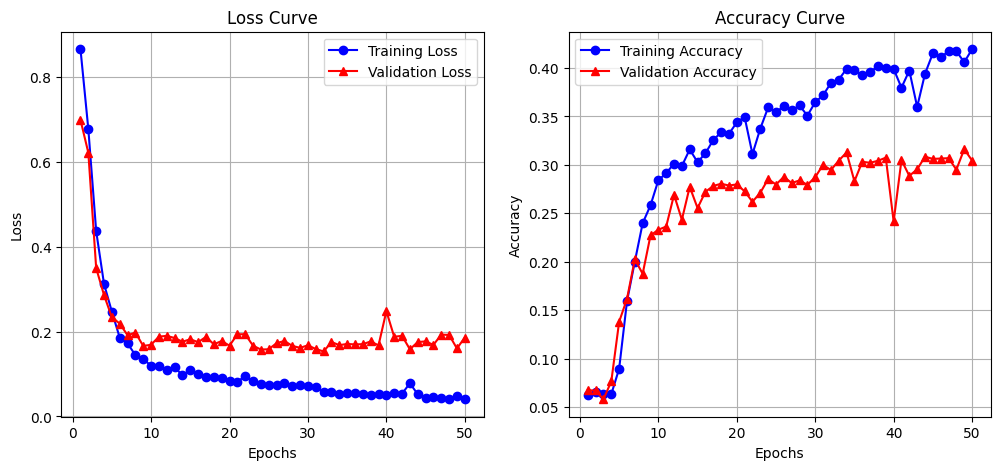

In [53]:
import matplotlib.pyplot as plt

# Extract loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('iou_score', history.history.get('acc'))  # Handle different Keras versions
val_acc = history.history.get('val_iou_score', history.history.get('val_acc'))

epochs = range(1, len(train_loss) + 1)

# 📌 Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' = blue circle markers with line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' = red triangle markers with line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# 📌 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


In [54]:
teacher_model.save("teacher_model.keras")
baseline_unet_model.save("baseline_model.keras")
student_model.save("student_model.keras")
hierarchical_teacher_model.save("hierarchical_teacher_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


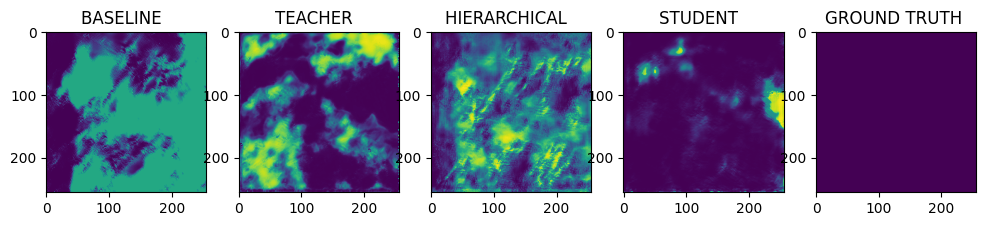

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


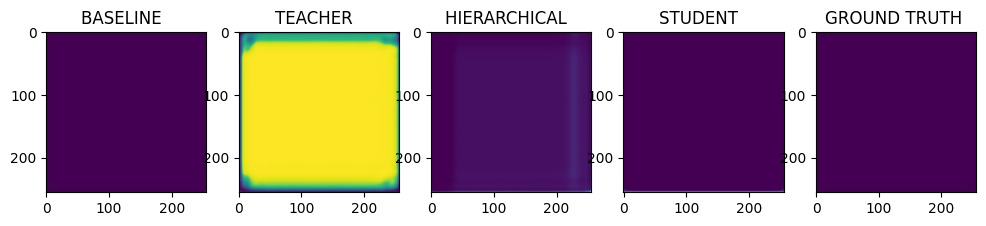

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


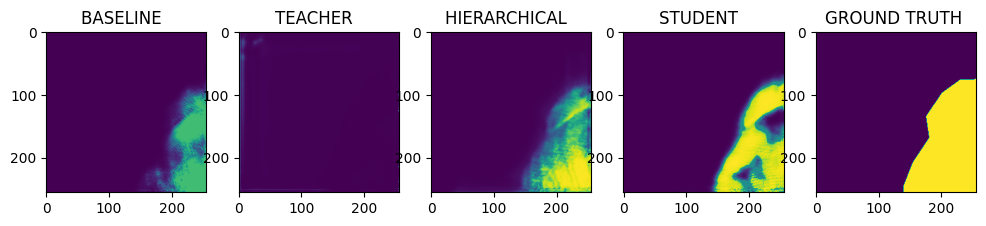

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


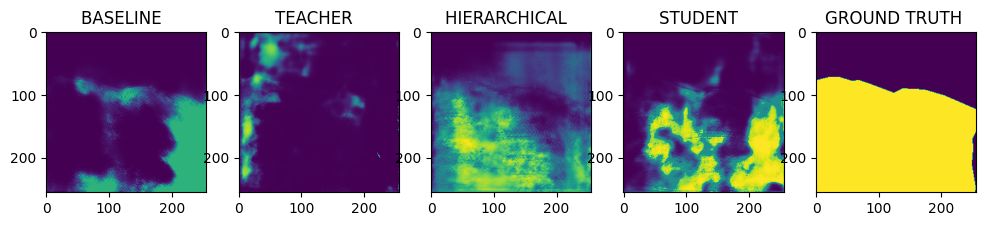

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


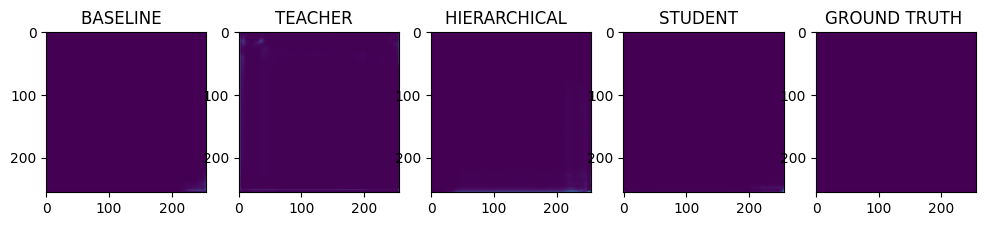

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


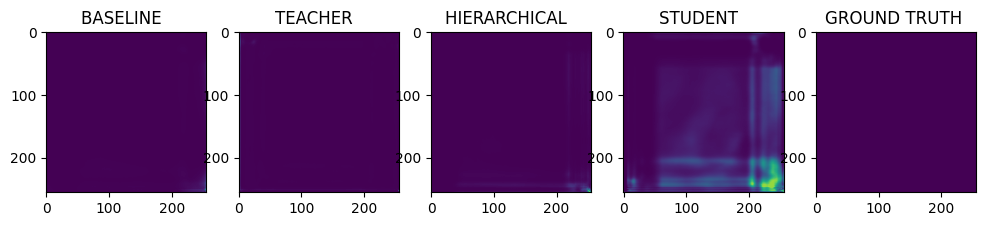

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


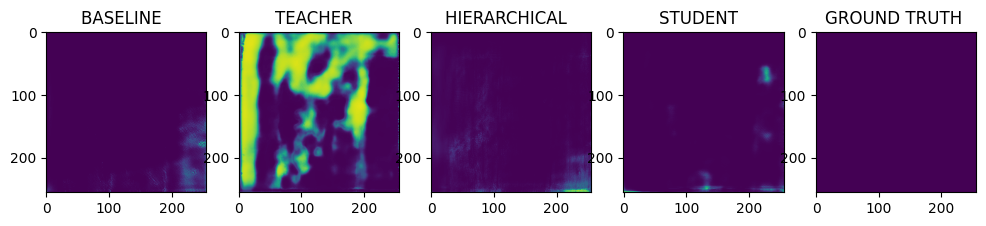

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


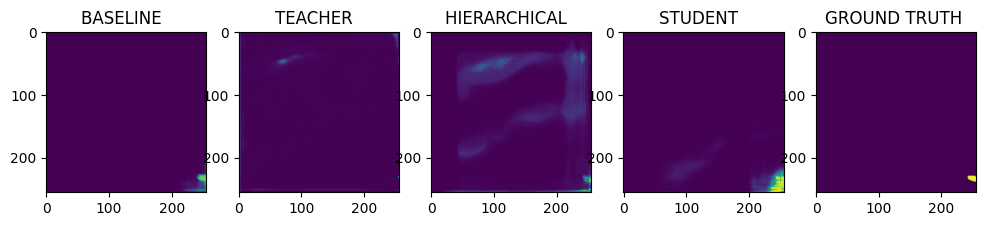

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


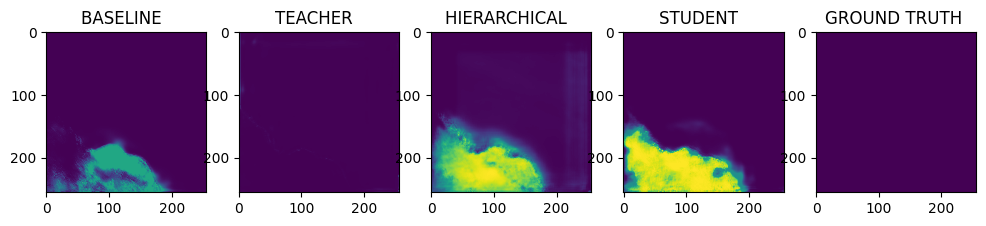

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


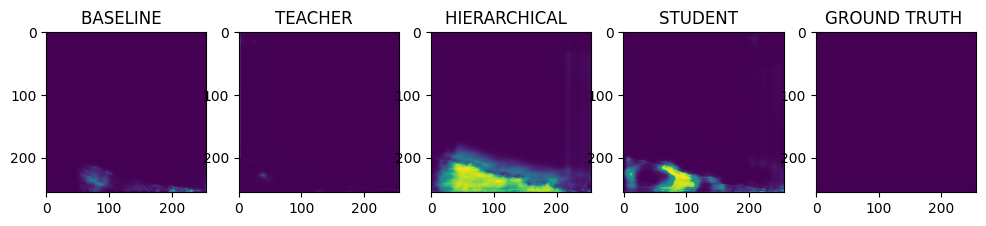

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


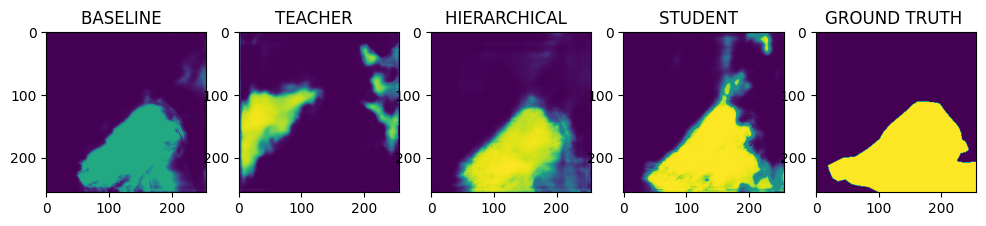

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


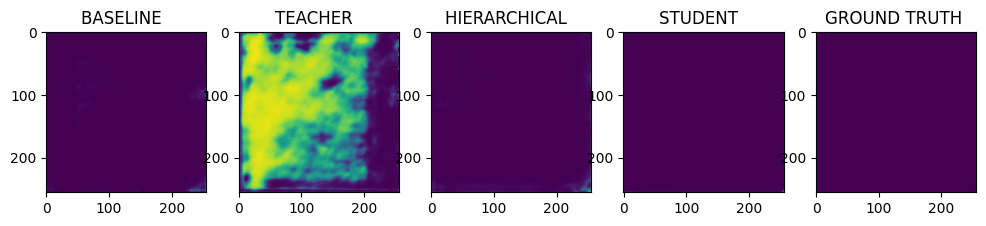

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


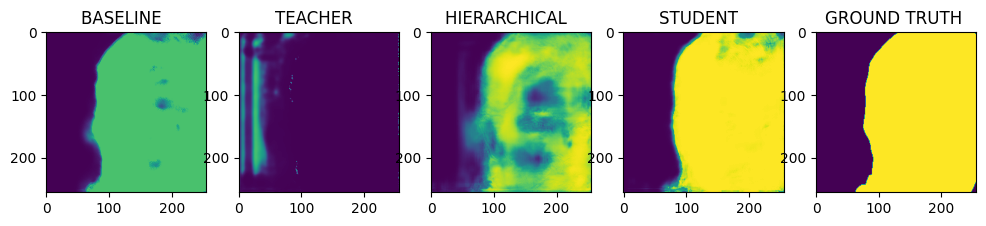

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


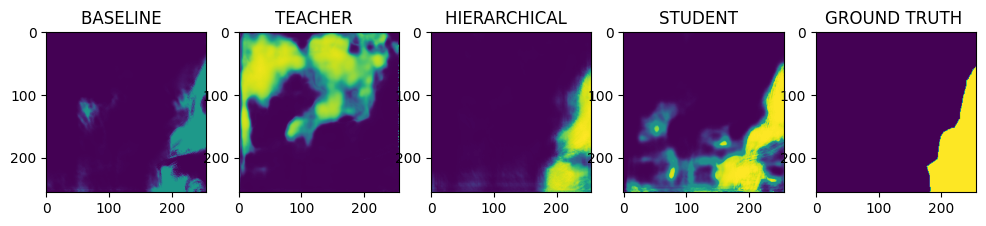

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


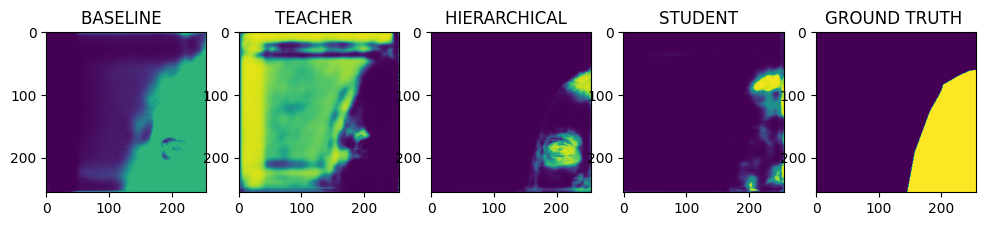

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


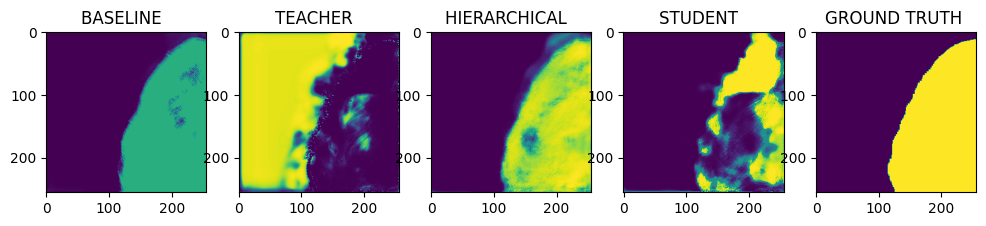

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


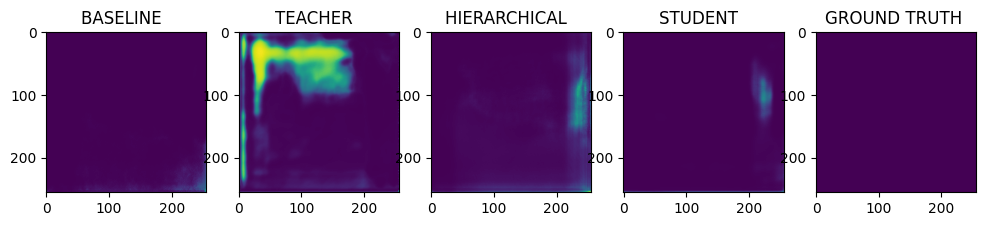

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


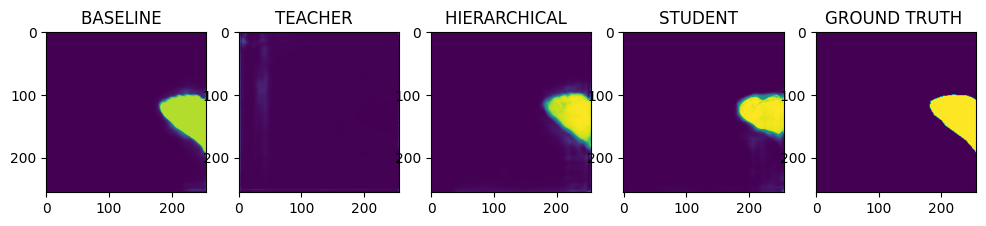

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


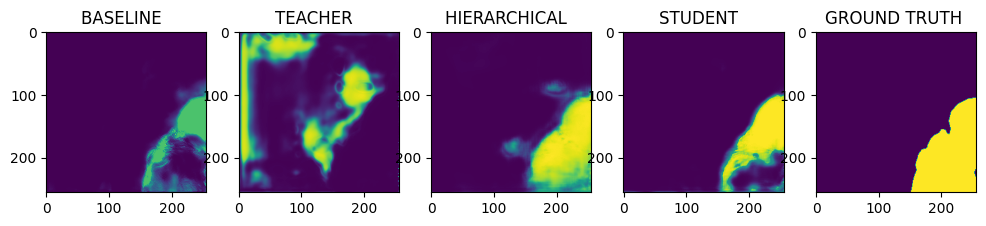

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


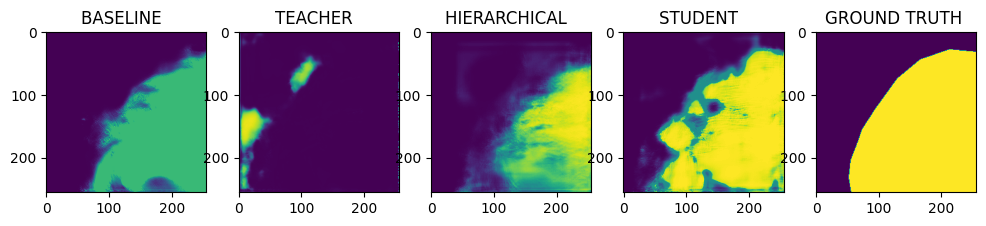

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


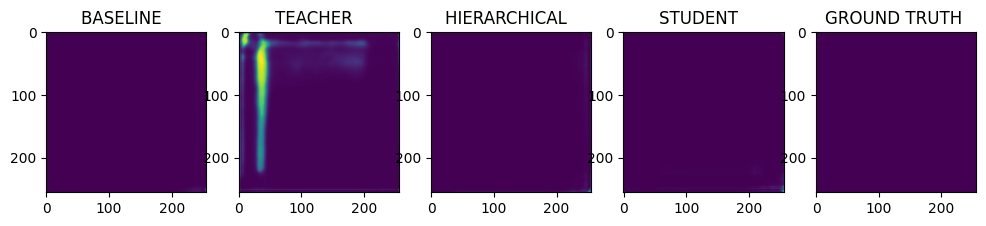

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


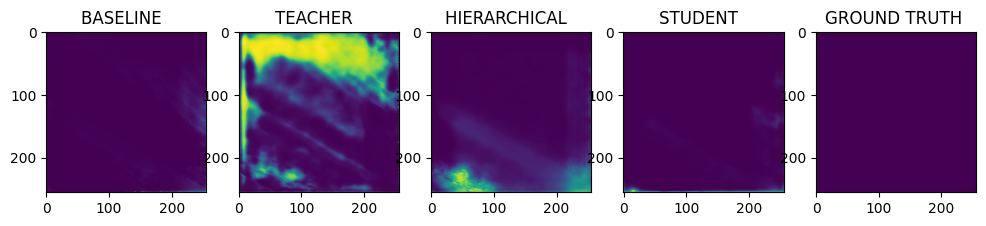

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


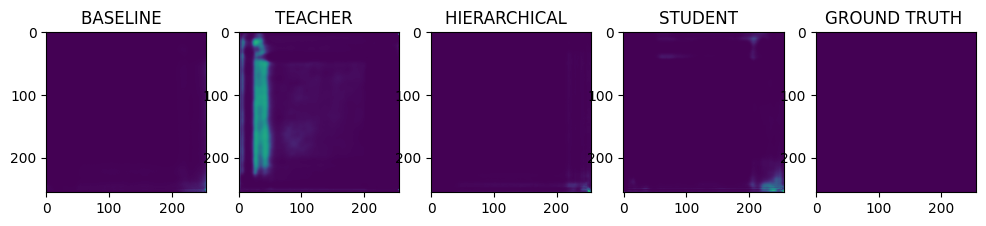

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


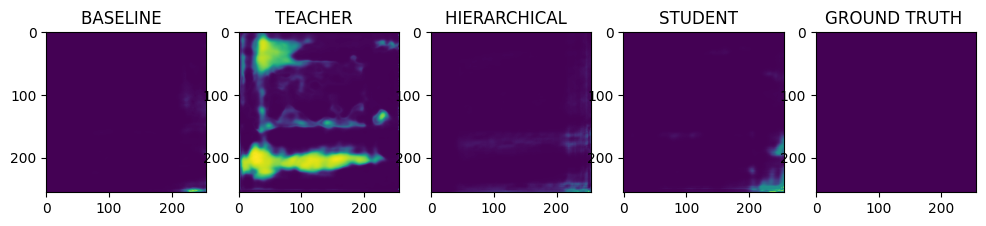

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


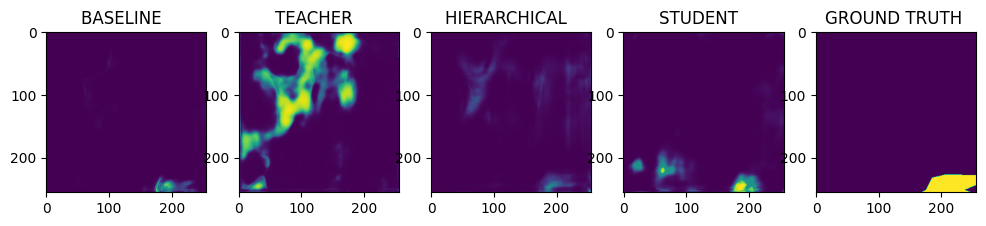

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


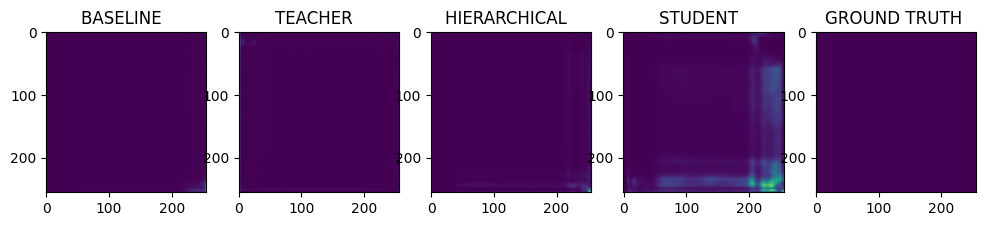

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


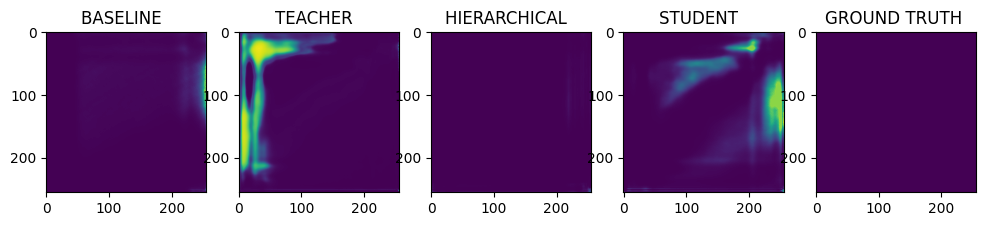

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


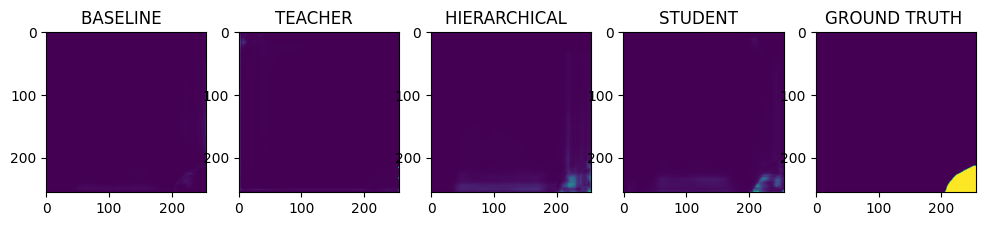

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


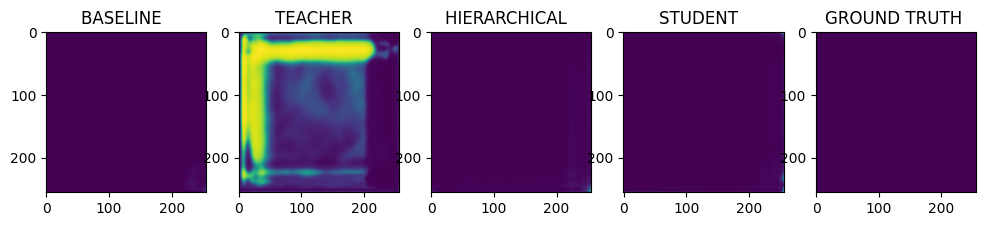

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


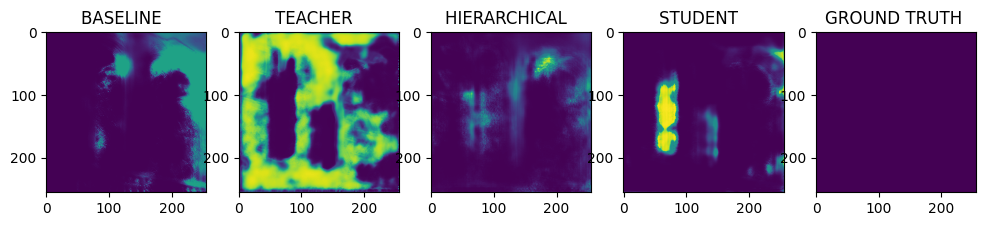

In [60]:
#lets get some predictions
for i in range(30):
    image = test_image[i]
    mask_actual = test_mask[i]
    expanded = np.expand_dims(image,axis = 0)
    #now lets predict  the semantic maps 

    baseline_prediction = baseline_unet_model.predict(expanded)
    baseline_prediction = baseline_prediction.squeeze(axis =(0,-1))
    teacher_prediction = teacher_model.predict(expanded)
    teacher_prediction = teacher_prediction.squeeze(axis =(0,-1))
    hierarchical_prediction = hierarchical_teacher_model.predict(expanded)
    hierarchical_prediction = hierarchical_prediction.squeeze(axis =(0,-1))
    student_prediction = student_model.predict(expanded)
    student_prediction = student_prediction.squeeze(axis =(0,-1))

    

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(baseline_prediction)
    plt.title("BASELINE  ")

    plt.subplot(1, 5, 2)
    plt.imshow(teacher_prediction)
    plt.title("TEACHER  ")

    plt.subplot(1, 5, 3)
    plt.imshow(hierarchical_prediction)
    plt.title("HIERARCHICAL  ")

    plt.subplot(1, 5, 4)
    plt.imshow(student_prediction)
    plt.title("STUDENT  ")

    plt.subplot(1, 5, 5)
    plt.imshow(mask_actual)
    plt.title("GROUND TRUTH ")


 
    plt.show()

    